In [1]:
import torch as pt
import numpy as np
import numpy.random as rnd
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.integrate as itg

from IPython import display
import time

import mechsamp as ms
from importlib import reload

%matplotlib inline

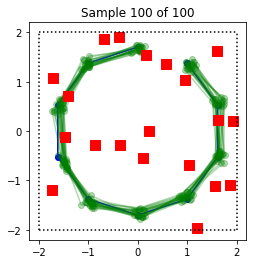

100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


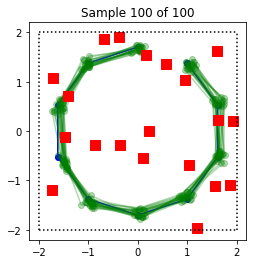

In [2]:
# Basic Smoothing
reload(ms)

NumSteps = 10

NumParticles = 20

#pt.manual_seed(388)
Width = 4
Unif = pt.distributions.Uniform(-Width/2,Width/2)

#
NumBeacons = 20
beaconLocations = Unif.sample((NumBeacons,2))


sensor_std = .2
noiseModel = pt.distributions.Normal(loc=0.,scale=sensor_std)


stepDist = pt.distributions.Normal(loc=0.,scale=1.)

def dist_fun(x):
    NumBeacons = len(beaconLocations)
    d = pt.norm(beaconLocations - pt.outer(pt.ones(NumBeacons),x),dim=1)
    return d
    
def proximityMeasurement(x):
    d = dist_fun(x)
    return d + sensor_std * pt.randn_like(d)


def measLL(x,y):
    d = dist_fun(x)
    return pt.sum(noiseModel.log_prob(y-d))


stepLL = lambda x_cur,x_next : stepDist.log_prob(x_next[:2]-x_cur[:2]).sum()



flat_prior = lambda x : 1.

A = pt.cat([pt.eye(2),
              -pt.eye(2)],dim=0)
b = pt.ones(4)*Width/2

    
    


Theta = pt.linspace(0,.9*2*np.pi,NumSteps)
phi = np.pi/2
X_true = 1.7 * pt.stack([pt.cos(Theta+phi),pt.sin(Theta+phi)],dim=1)
Y = pt.stack([proximityMeasurement(x) for x in X_true])

eta = 1e-3



# First-order Langevin
x_list = [Unif.sample((NumSteps*2,)).detach().clone().requires_grad_(True) for _ in range(NumParticles)]
sampler = ms.FOLangevinSmoother(flat_prior,measLL,stepLL,eta,Y,A,b)

NumSamples = 100

for samp in tqdm(range(NumSamples)):
    x_list = [sampler.step(x) for x in x_list]

    if ((samp+1) % 1) == 0:


        plt.clf()
        plt.plot(X_true[:,0],X_true[:,1],'b')
        plt.plot(X_true[:,0],X_true[:,1],'bo')
        for part in range(NumParticles):
            x = x_list[part]
            x_stacked = x[:2*NumSteps].view((NumSteps,2))
            x_np = x_stacked.detach().numpy()
            plt.plot(x_np[:,0],x_np[:,1],'g',alpha=.3)
            plt.plot(x_np[:,0],x_np[:,1],'go',alpha=.3)
        plt.plot(beaconLocations[:,0],beaconLocations[:,1],'s',color='r',markersize=10)

        plt.plot([-Width/2,-Width/2],[-Width/2,Width/2],'k:')
        plt.plot([Width/2,Width/2],[-Width/2,Width/2],'k:')
        plt.plot([-Width/2,Width/2],[Width/2,Width/2],'k:')
        plt.plot([-Width/2,Width/2],[-Width/2,-Width/2],'k:')
        plt.xlim([-2.2,2.2])
        plt.ylim([-2.2,2.2])
        plt.yticks([-2,-1,0,1,2])
        plt.title('Sample %d of %d' % (samp+1,NumSamples))
        plt.gca().set_aspect('equal')
    
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.5)
    
    
#X = pt.stack(X)
#X_np = X.detach().numpy()



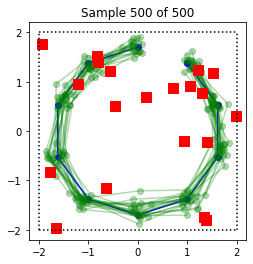

100%|██████████| 500/500 [06:47<00:00,  1.23it/s]


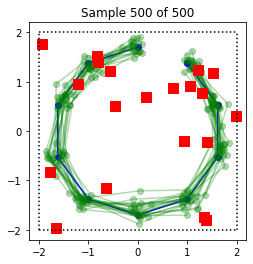

In [3]:
# Basic Smoothing with parameter ID
# Here, we are just identifying the scale parameters on the noise models
reload(ms)

NumSteps = 10

NumParticles = 20

NumBeacons = 20

#pt.manual_seed(388)
Width = 4
scaleMin = 0.1
scaleMax = 2.

def randomInitialization(NumSteps):
    StateInitDist = pt.distributions.Uniform(-Width/2,Width/2)
    ParamInitDist = pt.distributions.Uniform(scaleMin,scaleMax)
    x = pt.cat([StateInitDist.sample((2*NumSteps,)),
                ParamInitDist.sample((2,))])
    x = x.detach().clone().requires_grad_(True)
    return x


#

Unif = pt.distributions.Uniform(-Width/2,Width/2)
beaconLocations = Unif.sample((NumBeacons,2))


sensor_std = .2
noiseModel = pt.distributions.Normal(loc=0.,scale=1.)
stepDist = pt.distributions.Normal(loc=0.,scale=1.)

# Parameter
"""
params[0] - measurement scale
params[1] - step scale
"""

def dist_fun(x):
    NumBeacons = len(beaconLocations)
    d = pt.norm(beaconLocations - pt.outer(pt.ones(NumBeacons),x),dim=1)
    return d
    
def proximityMeasurement(x):
    d = dist_fun(x)
    return d + sensor_std * pt.randn_like(d)


def measLL(x,y,params):
    meas_scale = params[0]
    d = dist_fun(x)
    nY = len(y)
    LL = pt.sum(noiseModel.log_prob((y-d)/meas_scale)) - nY * pt.log(meas_scale)
    return LL


def stepLL(x_cur,x_next,params):
    step_scale = params[1]
    nX = 2
    LL = stepDist.log_prob((x_next[:2]-x_cur[:2])/step_scale).sum() - nX * pt.log(step_scale)
    return LL 



flat_init = lambda x,params : 1.
flat_prior = lambda params : 1.

A_s = pt.cat([pt.eye(2),
              -pt.eye(2)],dim=0)
b_s = pt.ones(4)*Width/2
A_p = A_s.detach().clone()
b_p = pt.tensor([scaleMax,scaleMax,-scaleMin,-scaleMin])

    
    


Theta = pt.linspace(0,.9*2*np.pi,NumSteps)
phi = np.pi/2
X_true = 1.7 * pt.stack([pt.cos(Theta+phi),pt.sin(Theta+phi)],dim=1)
Y = pt.stack([proximityMeasurement(x) for x in X_true])

eta = 1e-3



# First-order Langevin
x_list = [randomInitialization(NumSteps) for _ in range(NumParticles)]
sampler = ms.FOLangevinSmoothID(flat_init,measLL,stepLL,flat_prior,
                                eta,Y,
                                A_s=A_s,b_s=b_s,A_p=A_p,b_p=b_p)

NumSamples = 500

for samp in tqdm(range(NumSamples)):
    x_list = [sampler.step(x) for x in x_list]

    if ((samp+1) % 1) == 0:


        plt.clf()
        plt.plot(X_true[:,0],X_true[:,1],'b')
        plt.plot(X_true[:,0],X_true[:,1],'bo')
        for part in range(NumParticles):
            x = x_list[part]
            x_stacked = x[:2*NumSteps].view((NumSteps,2))
            x_np = x_stacked.detach().numpy()
            plt.plot(x_np[:,0],x_np[:,1],'g',alpha=.3)
            plt.plot(x_np[:,0],x_np[:,1],'go',alpha=.3)
        plt.plot(beaconLocations[:,0],beaconLocations[:,1],'s',color='r',markersize=10)

        plt.plot([-Width/2,-Width/2],[-Width/2,Width/2],'k:')
        plt.plot([Width/2,Width/2],[-Width/2,Width/2],'k:')
        plt.plot([-Width/2,Width/2],[Width/2,Width/2],'k:')
        plt.plot([-Width/2,Width/2],[-Width/2,-Width/2],'k:')
        plt.xlim([-2.2,2.2])
        plt.ylim([-2.2,2.2])
        plt.yticks([-2,-1,0,1,2])
        plt.title('Sample %d of %d' % (samp+1,NumSamples))
        plt.gca().set_aspect('equal')
    
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.5)
    
    
#X = pt.stack(X)
#X_np = X.detach().numpy()



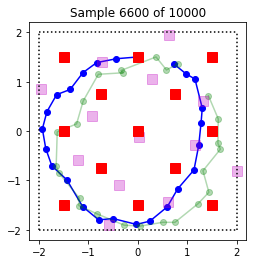

 66%|██████▋   | 6644/10000 [03:34<01:48, 31.00it/s]


KeyboardInterrupt: 

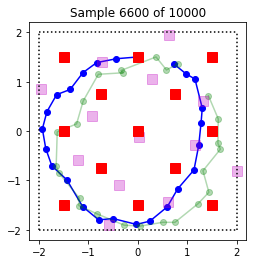

In [24]:
# SLAM
reload(ms)

NumSteps = 25

NumParticles = 1

NumBeacons = 24

#pt.manual_seed(388)
Width = 4
scaleMin = 0.05
scaleMax = .5

Unif = pt.distributions.Uniform(-Width/2,Width/2)
beaconLocations = Unif.sample((NumBeacons,2))

# Manual Beacons
beaconLocations = pt.tensor([[-1.5,-1.5],
                             [-1.5,0.],
                             [-1.5,1.5],
                             [0,-1.5],
                             [0,0.],
                             [0,1.5],
                             [1.5,-1.5],
                             [1.5,0],
                             [1.5,1.5],
                             [-.75,-.75],
                             [-.75,.75],
                             [.75,-.75],
                             [.75,.75]])

NumBeacons = len(beaconLocations)

def randomInitialization(NumSteps):
    StateInitDist = pt.distributions.Uniform(-Width/2,Width/2)
    ScaleInitDist = pt.distributions.Uniform(scaleMin,scaleMax)
    BeaconInitDist = pt.distributions.Uniform(-Width/2,Width/2)
    x = pt.cat([StateInitDist.sample((2*NumSteps,)),
                ScaleInitDist.sample((2,)),
                BeaconInitDist.sample((2*NumBeacons,))])
    x = x.detach().clone().requires_grad_(True)
    return x


#




sensor_std = .2
step_std = .1
noiseModel = pt.distributions.Normal(loc=0.,scale=1.)
stepDist = pt.distributions.Normal(loc=0.,scale=1.)

# Parameter
"""
params[0] - measurement scale
params[1] - step scale
param[2:] - locations of the beacons
"""

def dist_fun(x,locations):
    NumBeacons = len(locations)
    d = pt.norm(locations - pt.outer(pt.ones(NumBeacons),x),dim=1)
    return d
    
def proximityMeasurement(x):
    d = dist_fun(x,beaconLocations)
    return d + sensor_std * pt.randn_like(d)


def measLL(x,y,u,params):
    meas_scale = params[0]
    locations = params[2:].view((-1,2))
    d = dist_fun(x,locations)
    nY = len(y)
    LL = pt.sum(noiseModel.log_prob((y-d)/meas_scale)) - nY * pt.log(meas_scale)
    return LL


def stepLL(x_cur,x_next,u,params):
    step_scale = params[1]
    nX = 2
    LL = stepDist.log_prob((x_next[:2]-x_cur[:2]-u)/step_scale).sum() - nX * pt.log(step_scale)
    return LL 



flat_init = lambda x,params : 1.
flat_prior = lambda params : 1.

A_s = pt.cat([pt.eye(2),
              -pt.eye(2)],dim=0)
b_s = pt.ones(4)*Width/2
A_p = pt.kron(pt.eye(NumBeacons+1),A_s)
b_p = pt.cat([pt.tensor([scaleMax,scaleMax,-scaleMin,-scaleMin]),
              pt.kron(pt.ones(NumBeacons),b_s)])

    
    


Theta = pt.linspace(0,.9*2*np.pi,NumSteps)
phi = np.pi/2
X_ideal = 1.5 * pt.stack([pt.cos(Theta+phi),pt.sin(Theta+phi)],dim=1)
U = pt.cat([pt.diff(X_ideal,dim=0),pt.zeros((1,2))])
x_true = X_ideal[0]

X_true_list = [x_true]
for i in range(NumSteps-1):
    x_true = x_true + U[i] + step_std * pt.randn(2)
    x_true = pt.clamp(x_true,-Width/2,Width/2)
    X_true_list.append(x_true)
    
X_true = pt.stack(X_true_list,dim=0)
Y = pt.stack([proximityMeasurement(x) for x in X_true])

eta = 1e-4



# First-order Langevin
x_list = [randomInitialization(NumSteps) for _ in range(NumParticles)]
sampler = ms.FOLangevinSmoothID(flat_init,measLL,stepLL,flat_prior,
                                eta,Y,U,
                                A_s=A_s,b_s=b_s,A_p=A_p,b_p=b_p)

NumSamples = 10000

for samp in tqdm(range(NumSamples)):
    x_list = [sampler.step(x) for x in x_list]

    if ((samp+1) % 50) == 0:


        plt.clf()
        plt.plot(X_true[:,0],X_true[:,1],'b')
        plt.plot(X_true[:,0],X_true[:,1],'bo')
        for part in range(NumParticles):
            x = x_list[part]
            x_stacked = x[:2*NumSteps].view((NumSteps,2))
            x_np = x_stacked.detach().numpy()
            plt.plot(x_np[:,0],x_np[:,1],'g',alpha=.3)
            plt.plot(x_np[:,0],x_np[:,1],'go',alpha=.3)
            
            locations = x[2*NumSteps+2:].view((NumBeacons,2))
            locations_np = locations.detach().numpy()
            plt.plot(locations_np[:,0],locations_np[:,1],'s',color='m',markersize=10,alpha=.3)
        plt.plot(beaconLocations[:,0],beaconLocations[:,1],'s',color='r',markersize=10)

        plt.plot([-Width/2,-Width/2],[-Width/2,Width/2],'k:')
        plt.plot([Width/2,Width/2],[-Width/2,Width/2],'k:')
        plt.plot([-Width/2,Width/2],[Width/2,Width/2],'k:')
        plt.plot([-Width/2,Width/2],[-Width/2,-Width/2],'k:')
        plt.xlim([-2.2,2.2])
        plt.ylim([-2.2,2.2])
        plt.yticks([-2,-1,0,1,2])
        plt.title('Sample %d of %d' % (samp+1,NumSamples))
        plt.gca().set_aspect('equal')
    
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.5)
    
    
#X = pt.stack(X)
#X_np = X.detach().numpy()

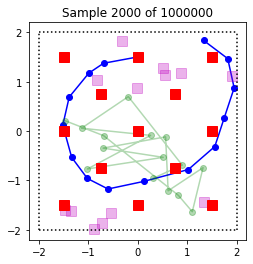

  0%|          | 1999/1000000 [00:03<26:19, 631.94it/s]


KeyboardInterrupt: 

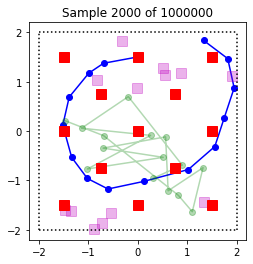

In [30]:
reload(ms)

NumSteps = 15


#pt.manual_seed(388)
Width = 4
scaleMin = 0.05
scaleMax = .5


NumBeacons = 24

# Random Beacons

Unif = pt.distributions.Uniform(-Width/2,Width/2)
beaconLocations = Unif.sample((NumBeacons,2))

# Manual Beacons
beaconLocations = pt.tensor([[-1.5,-1.5],
                             [-1.5,0.],
                             [-1.5,1.5],
                             [0,-1.5],
                             [0,0.],
                             [0,1.5],
                             [1.5,-1.5],
                             [1.5,0],
                             [1.5,1.5], 
                             [-.75,-.75],
                             [-.75,.75],
                             [.75,-.75],
                             [.75,.75]])

NumBeacons = len(beaconLocations)

def randomList(NumSteps):
    StateInitDist = pt.distributions.Uniform(-Width/2,Width/2)
    ScaleInitDist = pt.distributions.Uniform(scaleMin,scaleMax)
    BeaconInitDist = pt.distributions.Uniform(-Width/2,Width/2)
    state_list = [StateInitDist.sample((2,)).detach().clone().requires_grad_(True) \
                  for _ in range(NumSteps)]
    
    param = pt.cat([ScaleInitDist.sample((2,)),
                    BeaconInitDist.sample((2*NumBeacons,))])
    
    x = state_list + [param.detach().clone().requires_grad_(True)]
    return x





sensor_std = .2
step_std = .1
noiseModel = pt.distributions.Normal(loc=0.,scale=1.)
stepDist = pt.distributions.Normal(loc=0.,scale=1.)

# Parameter
"""
params[0] - measurement scale
params[1] - step scale
param[2:] - locations of the beacons
"""

def dist_fun(x,locations):
    NumBeacons = len(locations)
    d = pt.norm(locations - pt.outer(pt.ones(NumBeacons),x),dim=1)
    return d
    
def proximityMeasurement(x):
    d = dist_fun(x,beaconLocations)
    return d + sensor_std * pt.randn_like(d)


def measLL(x,y,u,params):
    meas_scale = params[0]
    locations = params[2:].view((-1,2))
    d = dist_fun(x,locations)
    nY = len(y)
    LL = pt.sum(noiseModel.log_prob((y-d)/meas_scale)) - nY * pt.log(meas_scale)
    return LL


def stepLL(x_cur,x_next,u,params):
    step_scale = params[1]
    nX = 2
    LL = stepDist.log_prob((x_next[:2]-x_cur[:2]-u)/step_scale).sum() - nX * pt.log(step_scale)
    return LL 


def flat_init(x,params):
    z = pt.cat([x,params])
    return 1. + pt.zeros_like(z)@z

def flat_prior(params):
    return 1. + pt.zeros_like(params)@params


A_s = pt.cat([pt.eye(2),
              -pt.eye(2)],dim=0)
b_s = pt.ones(4)*Width/2
A_p = pt.kron(pt.eye(NumBeacons+1),A_s)
b_p = pt.cat([pt.tensor([scaleMax,scaleMax,-scaleMin,-scaleMin]),
              pt.kron(pt.ones(NumBeacons),b_s)])

    
    


Theta = pt.linspace(0,.9*2*np.pi,NumSteps)
phi = np.pi/2
X_ideal = 1.5 * pt.stack([pt.cos(Theta+phi),pt.sin(Theta+phi)],dim=1)
U = pt.cat([pt.diff(X_ideal,dim=0),pt.zeros((1,2))])
x_true = X_ideal[0]

X_true_list = [x_true]
for i in range(NumSteps-1):
    x_true = x_true + U[i] + step_std * pt.randn(2)
    x_true = pt.clamp(x_true,-Width/2,Width/2)
    X_true_list.append(x_true)
    
X_true = pt.stack(X_true_list,dim=0)
Y = pt.stack([proximityMeasurement(x) for x in X_true])

eta = 1e-5



# First-order Langevin
x = randomList(NumSteps)



sampler = ms.SGSmoothID(flat_init,measLL,stepLL,flat_prior,
                        eta,Y,U,
                        A_s=A_s,b_s=b_s,A_p=A_p,b_p=b_p)

NumSamples = int(1e6)

for samp in tqdm(range(NumSamples)):
    x = sampler.step(x)
    shapes = [xi.shape for xi in x]

    if ((samp+1) % (int(1e3))) == 0:


        plt.clf()
        plt.plot(X_true[:,0],X_true[:,1],'b')
        plt.plot(X_true[:,0],X_true[:,1],'bo')
        
        #x_stacked = x[:2*NumSteps].view((NumSteps,2))
        x_stacked = pt.stack([x[i] for i in range(NumSteps)],dim=0)
        x_np = x_stacked.detach().numpy()
        plt.plot(x_np[:,0],x_np[:,1],'g',alpha=.3)
        plt.plot(x_np[:,0],x_np[:,1],'go',alpha=.3)
            
        locations = x[NumSteps][2:].view((NumBeacons,2))
        locations_np = locations.detach().numpy()
        plt.plot(locations_np[:,0],locations_np[:,1],'s',color='m',markersize=10,alpha=.3)
        
        plt.plot(beaconLocations[:,0],beaconLocations[:,1],'s',color='r',markersize=10)

        plt.plot([-Width/2,-Width/2],[-Width/2,Width/2],'k:')
        plt.plot([Width/2,Width/2],[-Width/2,Width/2],'k:')
        plt.plot([-Width/2,Width/2],[Width/2,Width/2],'k:')
        plt.plot([-Width/2,Width/2],[-Width/2,-Width/2],'k:')
        plt.xlim([-2.2,2.2])
        plt.ylim([-2.2,2.2])
        plt.yticks([-2,-1,0,1,2])
        plt.title('Sample %d of %d' % (samp+1,NumSamples))
        plt.gca().set_aspect('equal')
    
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.5)
    
    

In [29]:
len(sampler.var_dict)

31